# Importing essential libraries and packages

In [92]:
# Importing necessary packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
%matplotlib inline 

# Importing rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw


# Importing sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# Exploring the data set

In [93]:
# Load the data set
df = pd.read_csv("enthalpy_data.csv")
df.head()

,No.,Smiles,Enthalpy(kcal)
0,1,CCCCCCCCCCCCCCCCCC,-99.091888
1,2,CCCCCCCCCCCCCCCC,-89.480000
2,3,CCCCC(C)(C)CC(C)(C)CCCC,-87.619600
3,4,CCCC(C)(CC)CC(C)(CC)CCC,-82.958983
4,5,CCCCCCCCCCCCCCC,-84.390000


In [94]:
# Print numbers of rows and columns for this data set
print(f'No. of rows {df.shape[0]}, no of columns {df.shape[1]}')

No. of rows 309, no of columns 3


In [95]:
# Print summary statistics for this dataset
df.describe()   

,No.,Enthalpy(kcal)
count,309.000000,309.000000
mean,155.000000,-13.362183
std,89.344838,34.659713
min,1.000000,-99.091888
25%,78.000000,-25.960000
50%,155.000000,-21.390000
75%,232.000000,11.810000
max,309.000000,160.130000


In [96]:
# Check if there are any missing values
df.isnull().sum(axis=0)

No.               0
Smiles            0
Enthalpy(kcal)    0
dtype: int64

In [97]:
# Data format for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   No.             309 non-null    int64  
 1   Smiles          309 non-null    object 
 2   Enthalpy(kcal)  309 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.4+ KB


# Data pre-processing

In [98]:
# Column names
df.columns

Index(['No.', 'Smiles', 'Enthalpy(kcal)'], dtype='object')

In [99]:
# Drop column No.
df.drop('No.', axis=1, inplace=True)

In [100]:
df

,Smiles,Enthalpy(kcal)
0,CCCCCCCCCCCCCCCCCC,-99.091888
1,CCCCCCCCCCCCCCCC,-89.480000
2,CCCCC(C)(C)CC(C)(C)CCCC,-87.619600
3,CCCC(C)(CC)CC(C)(CC)CCC,-82.958983
4,CCCCCCCCCCCCCCC,-84.390000
...,...,...
304,C=C=CCC,33.630000
305,C=C=C=C,76.700000
306,C=CC=C,26.240000
307,C=C=CC,38.790000


In [101]:
# Renaming the two columns
df.rename(columns={'Enthalpy(kcal)': 'enthalpy_exp', 'Smiles':'SMILES'}, inplace=True)
df

,SMILES,enthalpy_exp
0,CCCCCCCCCCCCCCCCCC,-99.091888
1,CCCCCCCCCCCCCCCC,-89.480000
2,CCCCC(C)(C)CC(C)(C)CCCC,-87.619600
3,CCCC(C)(CC)CC(C)(CC)CCC,-82.958983
4,CCCCCCCCCCCCCCC,-84.390000
...,...,...
304,C=C=CCC,33.630000
305,C=C=C=C,76.700000
306,C=CC=C,26.240000
307,C=C=CC,38.790000


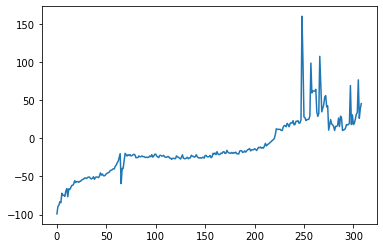

In [102]:
# Show distribution of the experimental enthalpy of formation
plt.plot(df['enthalpy_exp'].to_numpy())

In [103]:
# Convert SMILES to 2D molecules:
molecules = df.SMILES.apply(Chem.MolFromSmiles)

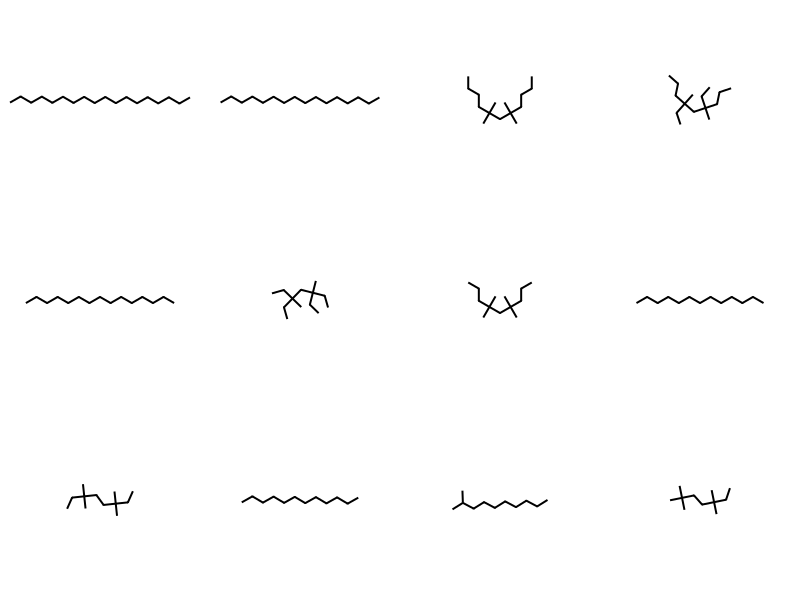

In [104]:
# Display some of the moecules
Draw.MolsToGridImage(molecules[:12],molsPerRow=4)

Create a function to calculate all the molecular descriptors in rdkit for a specific molecule.

In [105]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [106]:
# Calcualte molecular descriptors for all the hydrocarbons and store them in all_descriptors
all_descriptors = [getMolDescriptors(m) for m in molecules]

In [107]:
# Make a data frame of all molecular descriptors
data = pd.DataFrame(all_descriptors)
data.head()


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2.293903,2.293903,1.373270,1.373270,0.269541,11.000,254.502,216.198,254.297351,110,...,0,0,0,0,0,0,0,0,13,0
1,2.290220,2.290220,1.372778,1.372778,0.314905,10.875,226.448,192.176,226.266051,98,...,0,0,0,0,0,0,0,0,11,0
2,2.440829,2.440829,0.534972,0.534972,0.476106,13.200,212.421,180.165,212.250401,92,...,0,0,0,0,0,0,0,0,0,0
3,2.486181,2.486181,0.578056,0.578056,0.476106,19.600,212.421,180.165,212.250401,92,...,0,0,0,0,0,0,0,0,0,0
4,2.287998,2.287998,1.372449,1.372449,0.342950,10.800,212.421,180.165,212.250401,92,...,0,0,0,0,0,0,0,0,10,0


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Columns: 210 entries, MaxAbsEStateIndex to fr_urea
dtypes: float64(106), int64(104)
memory usage: 507.1 KB


In [109]:
data.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,309.0,309.0,309.0,309.000000,309.0,309.0,309.0,309.0,309.000000,309.0
mean,2.977320,2.977320,0.960809,0.960809,0.448168,10.470612,101.812411,87.419867,101.729851,43.391586,...,0.0,0.0,0.0,0.103560,0.0,0.0,0.0,0.0,0.453074,0.0
std,0.886217,0.886217,0.457109,0.457109,0.053330,3.019031,30.107402,25.109426,30.083565,13.371517,...,0.0,0.0,0.0,0.335585,0.0,0.0,0.0,0.0,1.644125,0.0
min,2.000000,2.000000,0.069444,0.069444,0.255574,1.000000,26.038000,24.022000,26.015650,10.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
25%,2.253472,2.253472,0.699074,0.699074,0.410515,8.857143,82.146000,72.066000,82.078250,34.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
50%,2.354167,2.354167,0.882407,0.882407,0.459028,10.750000,100.205000,84.077000,100.125201,44.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
75%,3.658321,3.658321,1.200521,1.200521,0.489976,12.714286,112.216000,96.088000,112.125201,48.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
max,5.278056,5.278056,4.000000,4.000000,0.572798,19.600000,254.502000,216.198000,254.297351,110.000000,...,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0,13.000000,0.0


In [110]:
# Calculate the mean of each column
column_means = data.mean()

# Identify columns with mean equal to 0
zero_mean_columns = column_means[column_means == 0].index

# Drop columns with mean equal to 0
data = data.drop(zero_mean_columns, axis=1)
data.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,VSA_EState7,VSA_EState8,FractionCSP3,HeavyAtomCount,NumRotatableBonds,MolLogP,MolMR,fr_allylic_oxid,fr_term_acetylene,fr_unbrch_alkane
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,2.977320,2.977320,0.960809,0.960809,0.448168,10.470612,101.812411,87.419867,101.729851,43.391586,...,4.752747,7.302687,0.700433,7.278317,2.281553,2.671878,35.294502,1.119741,0.103560,0.453074
std,0.886217,0.886217,0.457109,0.457109,0.053330,3.019031,30.107402,25.109426,30.083565,13.371517,...,3.445252,2.890029,0.242159,2.090536,2.117111,0.930835,9.841765,1.029704,0.335585,1.644125
min,2.000000,2.000000,0.069444,0.069444,0.255574,1.000000,26.038000,24.022000,26.015650,10.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.249400,9.890000,0.000000,0.000000,0.000000
25%,2.253472,2.253472,0.699074,0.699074,0.410515,8.857143,82.146000,72.066000,82.078250,34.000000,...,2.416019,5.423611,0.666667,6.000000,1.000000,2.138600,29.628000,0.000000,0.000000,0.000000
50%,2.354167,2.354167,0.882407,0.882407,0.459028,10.750000,100.205000,84.077000,100.125201,44.000000,...,4.356481,6.785417,0.750000,7.000000,2.000000,2.752700,34.363000,1.000000,0.000000,0.000000
75%,3.658321,3.658321,1.200521,1.200521,0.489976,12.714286,112.216000,96.088000,112.125201,48.000000,...,6.417964,8.808565,0.750000,8.000000,3.000000,2.998700,38.910000,2.000000,0.000000,0.000000
max,5.278056,5.278056,4.000000,4.000000,0.572798,19.600000,254.502000,216.198000,254.297351,110.000000,...,23.412193,16.300301,1.000000,18.000000,15.000000,7.267800,85.220000,6.000000,2.000000,13.000000


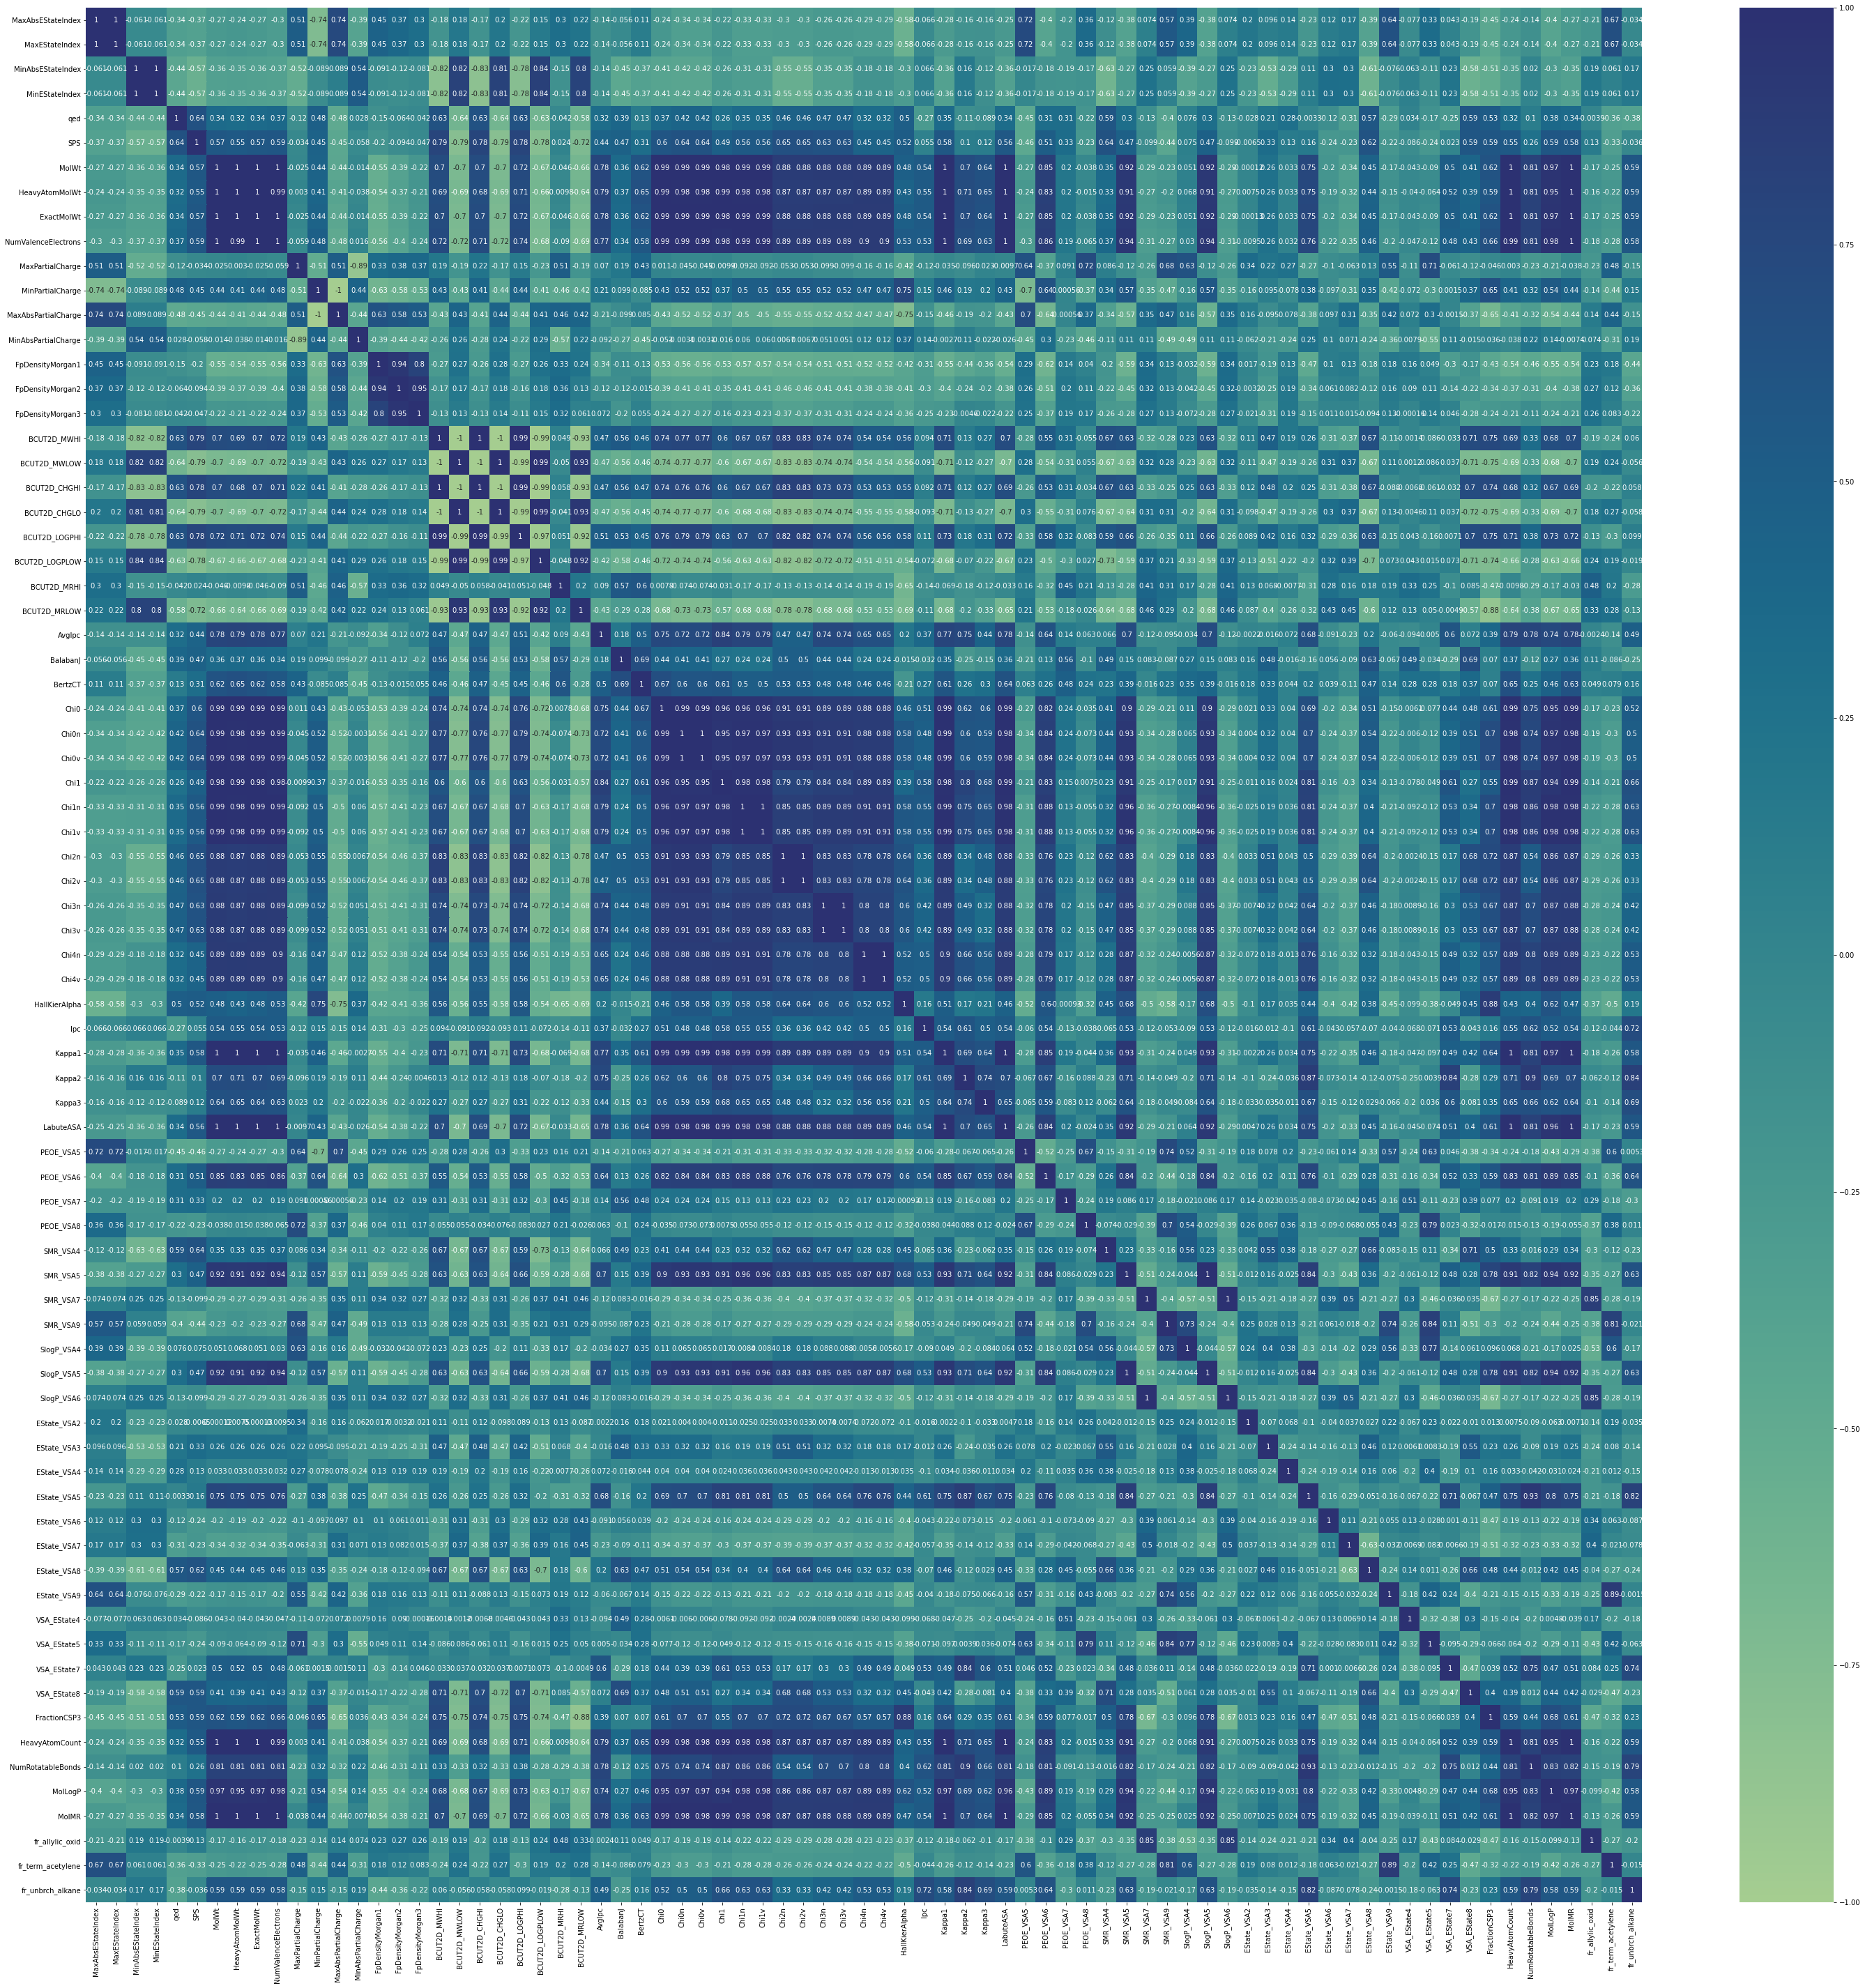

In [111]:
# Plotting the heatmap of the dataset
plt.figure(figsize=(50,50))
heatmap_plot = sns.heatmap(data.corr(), cmap="crest", annot=True)
plt.show()

In [112]:
merged_df = pd.concat([df, data], axis=1)
merged_df.head()

,SMILES,enthalpy_exp,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,VSA_EState7,VSA_EState8,FractionCSP3,HeavyAtomCount,NumRotatableBonds,MolLogP,MolMR,fr_allylic_oxid,fr_term_acetylene,fr_unbrch_alkane
0,CCCCCCCCCCCCCCCCCC,-99.091888,2.293903,2.293903,1.373270,1.373270,0.269541,11.000,254.502,216.198,...,23.412193,4.587807,1.0,18,15,7.2678,85.220,0,0,13
1,CCCCCCCCCCCCCCCC,-89.480000,2.290220,2.290220,1.372778,1.372778,0.314905,10.875,226.448,192.176,...,20.419560,4.580440,1.0,16,13,6.4876,75.986,0,0,11
2,CCCCC(C)(C)CC(C)(C)CCCC,-87.619600,2.440829,2.440829,0.534972,0.534972,0.476106,13.200,212.421,180.165,...,9.586769,14.343288,1.0,15,8,5.8093,71.229,0,0,0
3,CCCC(C)(CC)CC(C)(CC)CCC,-82.958983,2.486181,2.486181,0.578056,0.578056,0.476106,19.600,212.421,180.165,...,9.520928,14.322961,1.0,15,8,5.8093,71.229,0,0,0
4,CCCCCCCCCCCCCCC,-84.390000,2.287998,2.287998,1.372449,1.372449,0.342950,10.800,212.421,180.165,...,18.924004,4.575996,1.0,15,12,6.0975,71.369,0,0,10


# Model preparation

In [113]:
# Split the data set into features and targets
X = merged_df.iloc[:, 2:]
y = merged_df.enthalpy_exp
X.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,VSA_EState7,VSA_EState8,FractionCSP3,HeavyAtomCount,NumRotatableBonds,MolLogP,MolMR,fr_allylic_oxid,fr_term_acetylene,fr_unbrch_alkane
0,2.293903,2.293903,1.373270,1.373270,0.269541,11.000,254.502,216.198,254.297351,110,...,23.412193,4.587807,1.0,18,15,7.2678,85.220,0,0,13
1,2.290220,2.290220,1.372778,1.372778,0.314905,10.875,226.448,192.176,226.266051,98,...,20.419560,4.580440,1.0,16,13,6.4876,75.986,0,0,11
2,2.440829,2.440829,0.534972,0.534972,0.476106,13.200,212.421,180.165,212.250401,92,...,9.586769,14.343288,1.0,15,8,5.8093,71.229,0,0,0
3,2.486181,2.486181,0.578056,0.578056,0.476106,19.600,212.421,180.165,212.250401,92,...,9.520928,14.322961,1.0,15,8,5.8093,71.229,0,0,0
4,2.287998,2.287998,1.372449,1.372449,0.342950,10.800,212.421,180.165,212.250401,92,...,18.924004,4.575996,1.0,15,12,6.0975,71.369,0,0,10


In [114]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Create a function that generates mean squared error, mean absolute error, root mean squared error and R-squared and also plot the true values versus predictions

In [115]:
def evaluate_model(model, X, y):
    """
    Evaluate a machine learning model and report MSE, RMSE, MAE, and R2.

    Parameters:
    - model: The trained machine learning model.
    - X: Feature data for evaluation.
    - y: True target labels for evaluation.
    """
    # Predict the classes
    y_pred = model.predict(X)
    diff = y - y_pred
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(np.mean(np.square(diff)))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    
    plt.scatter(y_test, y_pred, label = "RMSE: {:.2f}\nR^2: {:.2f}".format(rmse, r2))
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

# Support Vector Regression

In [116]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Create an SVR model
svr = SVR()

# Train the model on the training set
svr.fit(X_train, y_train)

param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10, 100, 500, 1000, 2000],
    'epsilon': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'gamma': ['auto', 'scale']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Use the best hyperparameters to train the final model
final_model = grid_search.best_estimator_


Best Hyperparameters: {'C': 500, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


Mean Squared Error: 12.680486720010926
Root Mean Squared Error: 3.5609671045954534
Mean Absolute Error: 1.8027157315493583
R-squared: 0.9869475317487681


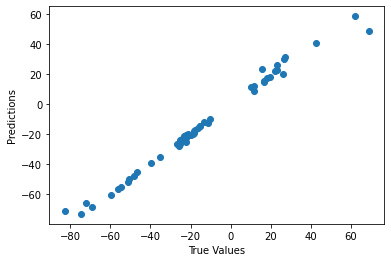

In [117]:
evaluate_model(final_model, X_test, y_test)

# Random Forest Regression

In [118]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search.best_params_
print(f'Best Hyperparameters for Random Forest: {best_params_rf}')

# Use the best hyperparameters to train the final Random Forest model
final_rf_model = grid_search.best_estimator_



Best Hyperparameters for Random Forest: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Mean Squared Error: 8.7007209126961
Root Mean Squared Error: 2.9496984443661525
Mean Absolute Error: 1.619690199411673
R-squared: 0.9910440438144557


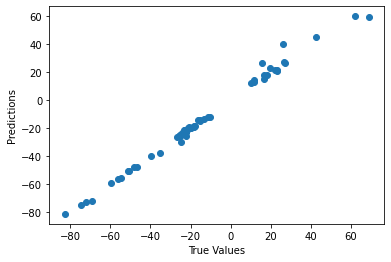

In [119]:
evaluate_model(final_rf_model, X_test, y_test)
